In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import pandas
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
import datasets as ds
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
import wandb



In [3]:
# wandb.init(
#     project="CryptopunkVAE",
#     config={
#         "learning_rate": 1e-3,
#         "epochs": 100,
#         "batch_size": 32,
#         "latent_dim": 512,
#         "beta": 0.5,
#         "wandb": True
#         })

In [19]:
# Auxillary functions
import torchvision.transforms as transforms
def collate_fn(batch):
    images = [item['image'] for item in batch]
    ids = [item['id'] for item in batch]
    token_metadata = [item['token_metadata'] for item in batch]
    image_original_url = [item['image_original_url'] for item in batch]

    # Convert images to PyTorch tensors
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    images = [transform(img) if isinstance(img, Image.Image) else transform(Image.fromarray(img)) for img in images]

    return {
        'image': torch.stack(images),
        'id': ids,
        'token_metadata': token_metadata,
        'image_original_url': image_original_url
    }

def save_images_to_tensorboard(writer, epoch, images, name):
    img_grid = torchvision.utils.make_grid(images, nrow=4)
    writer.add_image(name, img_grid, epoch)

In [20]:
# Model

class vae(nn.Module):
    def __init__(self,im_width, im_height, filter_size=[32, 64, 128, 256, 512], latent_dim=1024):
        super(vae, self).__init__()
        self.filter_size = [32, 64, 128, 256, 512, 1024]
        self.lantent_dim = latent_dim
        self.im_width = im_width
        self.im_height = im_height

        self.encoder_conv = nn.Sequential(
            self.conv_block(3, self.filter_size[0], (5,5), 2, 2),
            self.conv_block(self.filter_size[0], self.filter_size[1], (5,5), 2, 2),
            self.conv_block(self.filter_size[1], self.filter_size[2], (5,5), 2, 2),
            self.conv_block(self.filter_size[2], self.filter_size[3], (5,5), 2, 2),
            self.conv_block(self.filter_size[3], self.filter_size[4], (5,5), 2, 2),
            self.conv_block(self.filter_size[4], self.filter_size[5], (5,5), 2, 2),
        )


        self.decoder_conv = nn.Sequential(
            self.deconv_block(self.filter_size[5], self.filter_size[4], (5,5), 2, 2),
            self.deconv_block(self.filter_size[4], self.filter_size[3], (5,5), 2, 2),
            self.deconv_block(self.filter_size[3], self.filter_size[2], (5,5), 2, 2),
            self.deconv_block(self.filter_size[2], self.filter_size[1], (5,5), 2, 2),
            self.deconv_block(self.filter_size[1], self.filter_size[0], (5,5), 2, 2),
            self.deconv_block(self.filter_size[0], 3, (5,5), 2, 2),
        )

        self.encoder_mu = nn.Sequential(
            nn.Linear(in_features=1024 * 4 * 4, out_features=self.lantent_dim * 4),
            nn.Linear(self.lantent_dim * 4 , self.lantent_dim * 2),
            nn.Linear(self.lantent_dim * 2 , self.lantent_dim))

        self.encoder_var = nn.Sequential(
            nn.Linear(in_features=1024 * 4 * 4, out_features=self.lantent_dim * 4),
            nn.Linear(self.lantent_dim * 4 , self.lantent_dim * 2),
            nn.Linear(self.lantent_dim * 2 , self.lantent_dim))

        self.decoder = nn.Sequential(
            nn.Linear(self.lantent_dim, self.lantent_dim * 2),
            nn.BatchNorm1d(self.lantent_dim * 2),
            nn.LeakyReLU(0.02),
            nn.Linear(self.lantent_dim * 2, self.lantent_dim * 4),
            nn.BatchNorm1d(self.lantent_dim * 4),
            nn.LeakyReLU(0.02),
            nn.Linear(self.lantent_dim * 4 , 1024 * 4 * 4),
            nn.BatchNorm1d(1024 * 4 * 4),
            nn.LeakyReLU(0.02),
        )

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            # nn.MaxPool2d(2, 2) if out_channels != 512 else nn.Identity(),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.02)
        )

    def deconv_block(self, in_channels, out_channels, kernel_size, stride,padding=1):
        output_padding = 1 if stride == 2 else 0
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.02) if out_channels != 3 else nn.Sigmoid()

        )

    def encoder(self, x):
        x = self.encoder_conv(x)
        x = torch.flatten(x, 1)
        return self.encoder_mu(x), self.encoder_var(x)
        

    def forward(self, x, verbose=False):
        mu, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        z = self.decoder(z)
        z = z.view(-1, self.filter_size[5], 4, 4)
        z = self.decoder_conv(z)
        return z, mu, log_var


In [21]:
model = vae(im_width=256, im_height=256, latent_dim=1024)
random_input = torch.randn(4, 3, 256, 256)
output, mu, log_var = model(random_input)
assert random_input.shape == output.shape
print("Shapes match")

Shapes match


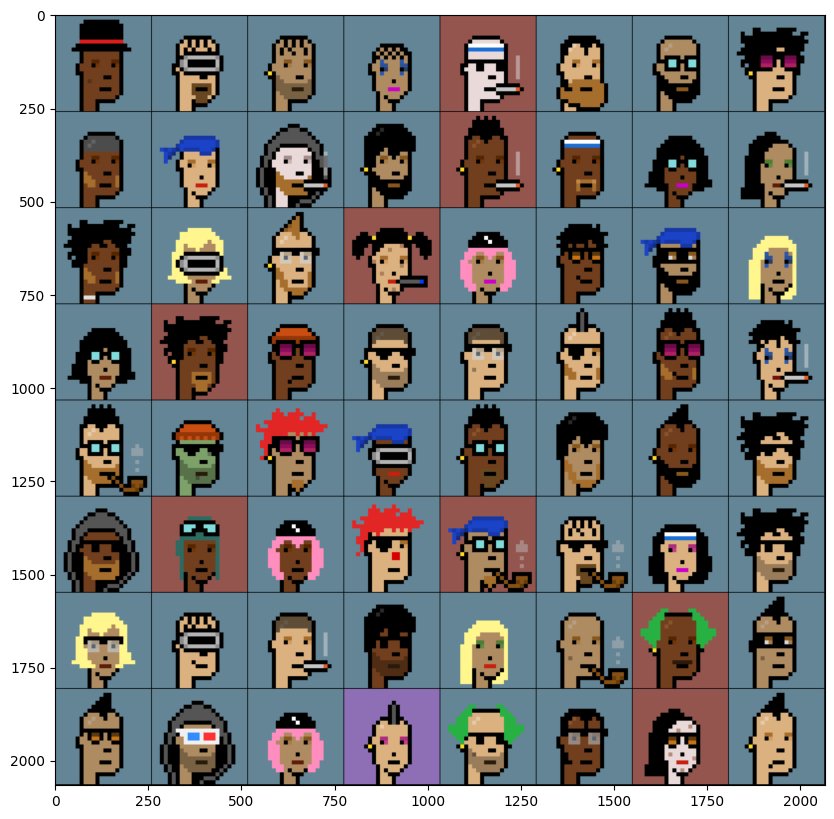

In [24]:
# Data loading and preprocessing
dataset = load_dataset("huggingnft/cryptopunks")
dataset = dataset['train'].train_test_split(test_size=0.1)

train_loader = DataLoader(dataset["train"], batch_size=64, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=8, collate_fn=collate_fn)

batch = next(iter(train_loader))
img_grid = torchvision.utils.make_grid(batch['image'], nrow=8)
fig = plt.figure(figsize=(10,10))
plt.imshow(img_grid.permute(1, 2, 0))
plt.show()

In [11]:
# Training Loop
# Hyperparameters
batch_size = 8
train_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)
epochs = 1000
lr = 4e-5
beta = 0.1
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = vae(im_width=256, im_height=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='sum').to(device)

writer = SummaryWriter()

batch = next(iter(train_loader))

for epoch in range(epochs):
    model.train()
    # loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    # for idx, batch in loop:

    img = batch['image'].to(device)
    
    reconstruction, mu, log_var = model(img)

    # Reconstruction loss
    reconstruction_loss = criterion(reconstruction, img)

    # KL Divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss
    total_loss = reconstruction_loss + beta *  kl_divergence
    print(f"Epoch: {epoch} Loss: {total_loss.item()}")

    # Backprop
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    writer.add_scalar('Loss/train', total_loss.item(), epoch)
    save_images_to_tensorboard(writer, epoch, img[:4,...], "Original")
    save_images_to_tensorboard(writer, epoch, reconstruction[:4,...], "Training Reconstruction")


    # # Validation
    # model.eval()
    # with torch.no_grad():
    #     for idx, batch in enumerate(test_loader):
    #         batch = batch['image'].to(device)
    #         reconstruction, mu, log_var = model(batch)

    #         # Reconstruction loss
    #         reconstruction_loss = criterion(reconstruction, batch)

    #         # KL Divergence
    #         kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    #         # Total loss
    #         total_val_loss = reconstruction_loss + beta *  kl_divergence

    #     writer.add_scalar('Loss/val', total_val_loss.item(), epoch)

    z = torch.randn(16, model.lantent_dim).to(device)
    z = model.decoder(z)
    z = z.view(16, 1024, 4, 4)
    z = model.decoder_conv(z)

    save_images_to_tensorboard(writer, epoch, z[:4,...], "Newly Generated")
    


Epoch: 0 Loss: 152089.09375
Epoch: 1 Loss: 149783.5
Epoch: 2 Loss: 146112.390625
Epoch: 3 Loss: 142012.3125
Epoch: 4 Loss: 138023.09375
Epoch: 5 Loss: 132004.3125
Epoch: 6 Loss: 124310.4140625
Epoch: 7 Loss: 154889.15625
Epoch: 8 Loss: 113655.0546875
Epoch: 9 Loss: 110053.359375
Epoch: 10 Loss: 107668.640625
Epoch: 11 Loss: 105791.015625
Epoch: 12 Loss: 104443.4609375
Epoch: 13 Loss: 103407.203125
Epoch: 14 Loss: 102054.078125
Epoch: 15 Loss: 101543.8515625
Epoch: 16 Loss: 100234.5625
Epoch: 17 Loss: 99795.5078125
Epoch: 18 Loss: 99474.734375
Epoch: 19 Loss: 99146.5546875
Epoch: 20 Loss: 98823.4765625
Epoch: 21 Loss: 98465.7109375
Epoch: 22 Loss: 98103.4375
Epoch: 23 Loss: 97728.0625
Epoch: 24 Loss: 97355.2890625
Epoch: 25 Loss: 96977.2265625
Epoch: 26 Loss: 96614.609375
Epoch: 27 Loss: 96259.0859375
Epoch: 28 Loss: 95936.4765625
Epoch: 29 Loss: 95590.5625
Epoch: 30 Loss: 95290.9765625
Epoch: 31 Loss: 94983.1484375
Epoch: 32 Loss: 94654.3125
Epoch: 33 Loss: 94386.9296875
Epoch: 34 Loss

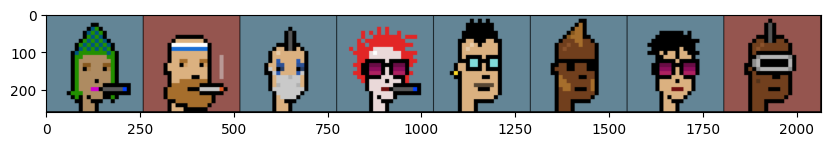

In [12]:
img_grid = torchvision.utils.make_grid(batch['image'].cpu(), nrow=10)
fig = plt.figure(figsize=(10,10))
plt.imshow(img_grid.permute(1, 2, 0))
plt.show()

In [25]:
model.eval()
with torch.no_grad():

    z = torch.normal(2, 1, size=(16, model.lantent_dim)).to(device)
    z = model.decoder(z)
    z = z.view(-1, 512, 8, 8)
    generated_images = model.decoder_conv(z)



    img_grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4)
    fig = plt.figure(figsize=(14,14))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.show()


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
# Visualise the latent space
model.eval()

test_loader = DataLoader(dataset["test"], batch_size=1000, collate_fn=collate_fn)
batch = next(iter(test_loader))

with torch.no_grad():
    mu, log_var = model.encoder(batch['image'].to(device))

In [ ]:
# Assume that `mu_vectors` is a 2D array of shape (n_images, latent_dim) containing
# the mu vectors for all of your images.

tsne = TSNE(n_components=2)
reduced_latents = tsne.fit_transform(mu.cpu())
# Assume that `reduced_latents` is a 2D array of shape (n_images, 2) containing
# the 2D representations of your images in the latent space, and `labels` is an
# array of shape (n_images,) containing a label for each image.

plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1])
plt.show()